# 数据分析尝试

In [8]:
#General
import pandas as pd
import numpy as np
import json

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore, Style, init;

# Modeling
import xgboost as xgb
import torch

# Geolocation
from geopy.geocoders import Nominatim

# Options
pd.set_option('display.max_columns', 100)

In [9]:
DEBUG = False # False/True
# GPU or CPU use for model
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
# Color printing
def print_color(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    '''Prints color outputs using colorama of a text string'''
    print(style + color + text + Style.RESET_ALL)

def display_df(df, name):
    '''Display df shape and first row '''
    print_color(text =f'{name} data has {df.shape[0]} rows and {df.shape[1]} columns. \n ===> First row:')
    display(df.head(5))

## 一、数据载入

In [10]:
DATA_DIR = "./data/predict-energy-behavior-of-prosumers/"

# Read CSVs and parse relevant date columns
train = pd.read_csv(DATA_DIR + "train.csv")
client = pd.read_csv(DATA_DIR + "client.csv")
historical_weather = pd.read_csv(DATA_DIR + "historical_weather.csv")
forecast_weather = pd.read_csv(DATA_DIR + "forecast_weather.csv")
electricity = pd.read_csv(DATA_DIR + "electricity_prices.csv")
gas = pd.read_csv(DATA_DIR + "gas_prices.csv")
# Location from https://www.kaggle.com/datasets/michaelo/fabiendaniels-mapping-locations-and-county-codes/data
location = (pd.read_csv("./data/fabiendaniels-mapping-locations-and-county-codes/county_lon_lats.csv")
            .drop(columns = ["Unnamed: 0"])
           )

### 1.处理train数据

In [12]:
train.head()

             county   is_business  product_type        target  is_consumption  \
count  2.018352e+06  2.018352e+06  2.018352e+06  2.017824e+06       2018352.0   
mean   7.297034e+00  5.368261e-01  1.898927e+00  2.748556e+02             0.5   
std    4.780990e+00  4.986421e-01  1.081766e+00  9.095024e+02             0.5   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00             0.0   
25%    3.000000e+00  0.000000e+00  1.000000e+00  3.780000e-01             0.0   
50%    7.000000e+00  1.000000e+00  2.000000e+00  3.113300e+01             0.5   
75%    1.100000e+01  1.000000e+00  3.000000e+00  1.802062e+02             1.0   
max    1.500000e+01  1.000000e+00  3.000000e+00  1.548027e+04             1.0   

       data_block_id        row_id  prediction_unit_id  
count   2.018352e+06  2.018352e+06        2.018352e+06  
mean    3.218746e+02  1.009176e+06        3.304538e+01  
std     1.826343e+02  5.826482e+05        1.959059e+01  
min     0.000000e+00  0.000000e+00        

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2


array([[<Axes: title={'center': 'county'}>,
        <Axes: title={'center': 'is_business'}>,
        <Axes: title={'center': 'product_type'}>],
       [<Axes: title={'center': 'target'}>,
        <Axes: title={'center': 'is_consumption'}>,
        <Axes: title={'center': 'data_block_id'}>],
       [<Axes: title={'center': 'row_id'}>,
        <Axes: title={'center': 'prediction_unit_id'}>, <Axes: >]],
      dtype=object)

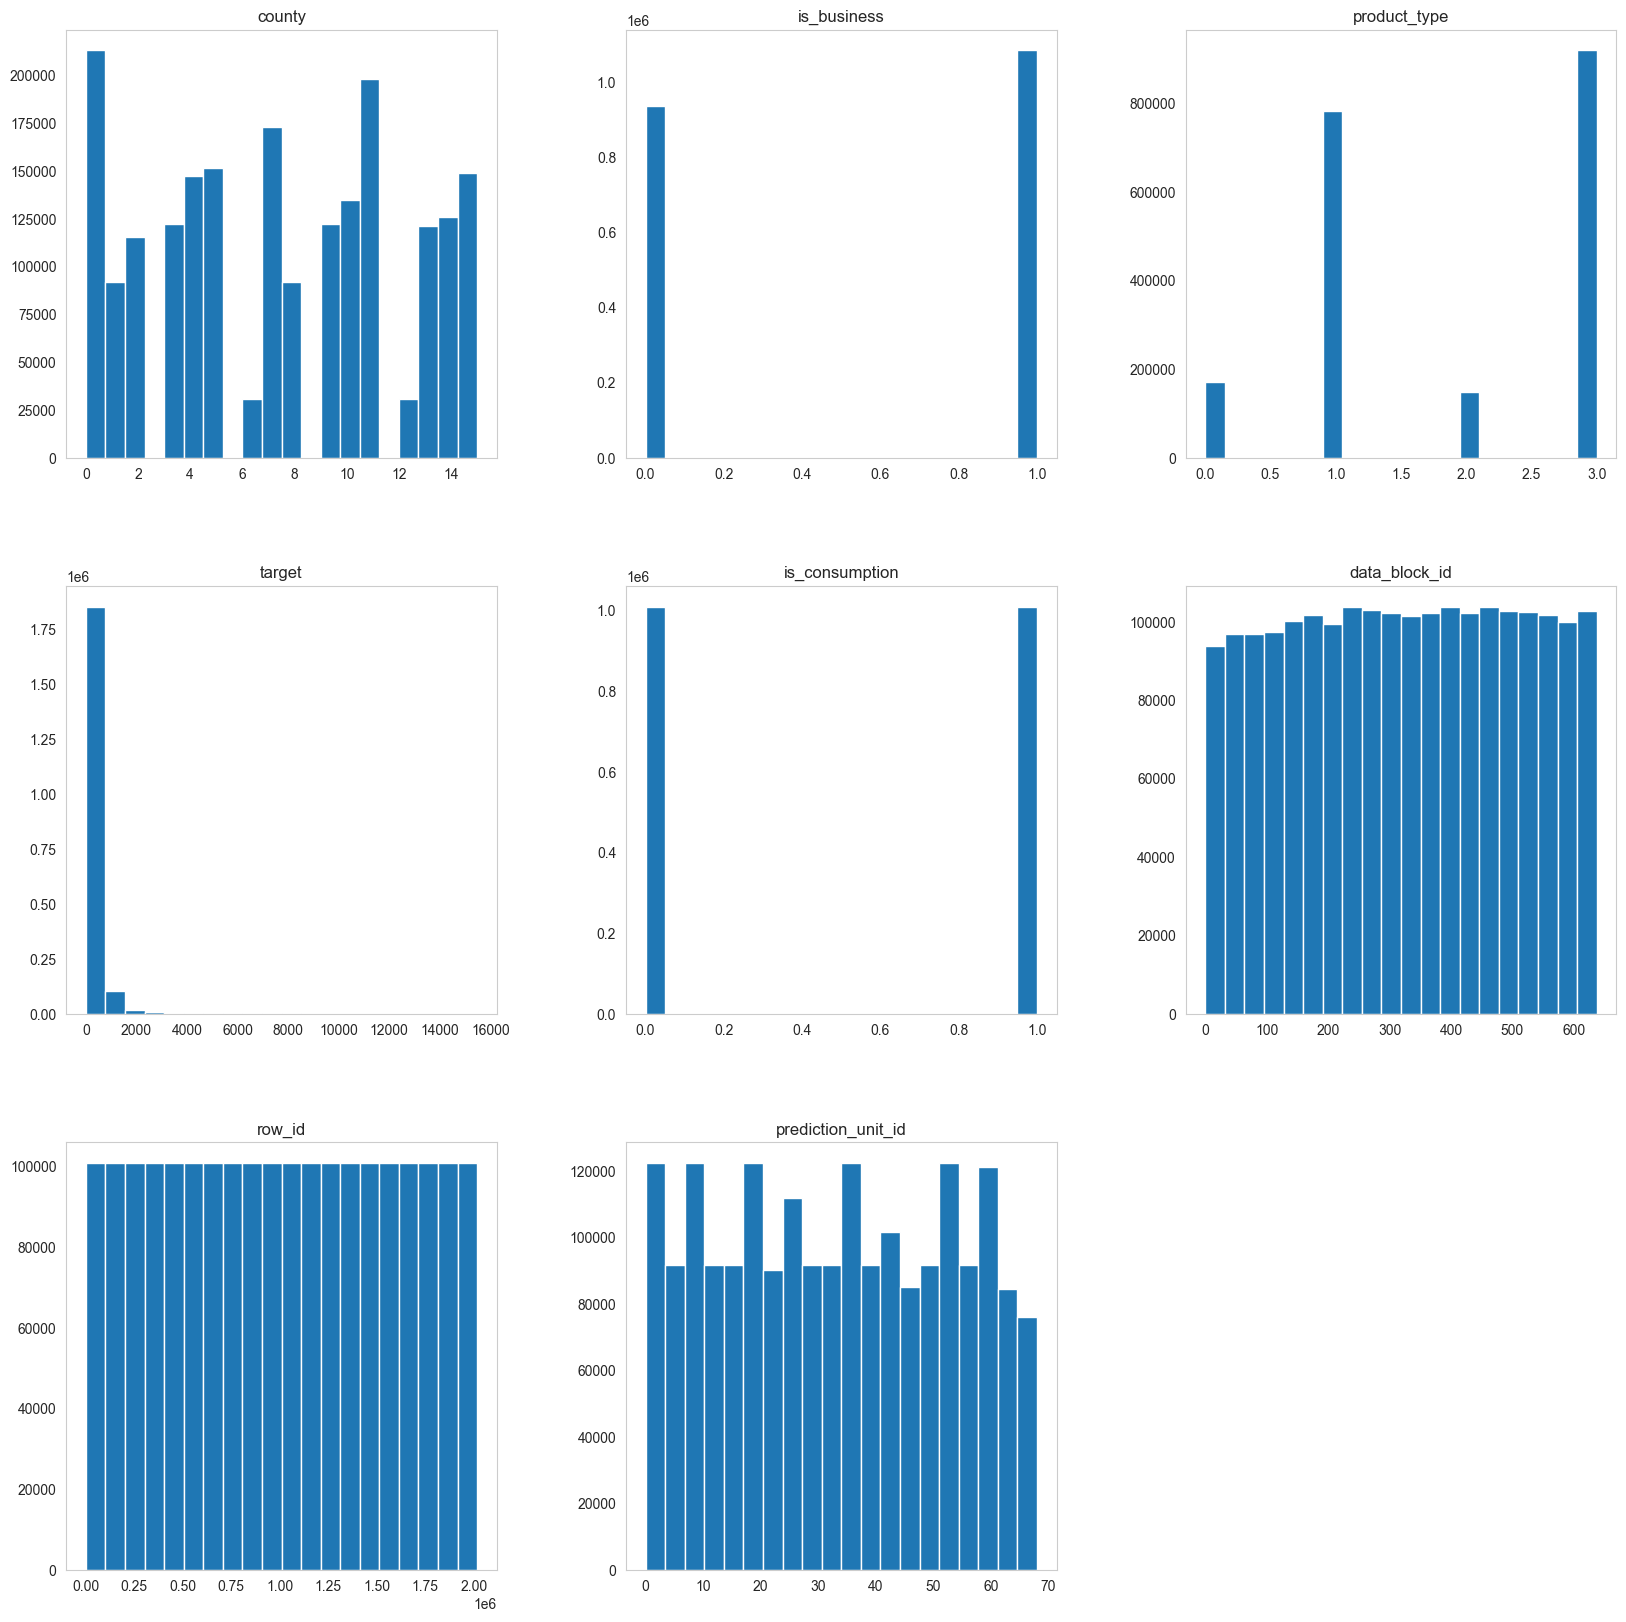

In [16]:
train.hist(bins=20,grid=False,figsize=(20,20))

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,year,quarter,month,week,hour,day_of_year,day_of_month,day_of_week
0,0,0,1,0.713,0,2021-09-01,0,0,0,2021-09-01,2021,3,9,35,0,244,1,2
1,0,0,1,96.590,1,2021-09-01,0,1,0,2021-09-01,2021,3,9,35,0,244,1,2
2,0,0,2,0.000,0,2021-09-01,0,2,1,2021-09-01,2021,3,9,35,0,244,1,2
3,0,0,2,17.314,1,2021-09-01,0,3,1,2021-09-01,2021,3,9,35,0,244,1,2
4,0,0,3,2.904,0,2021-09-01,0,4,2,2021-09-01,2021,3,9,35,0,244,1,2


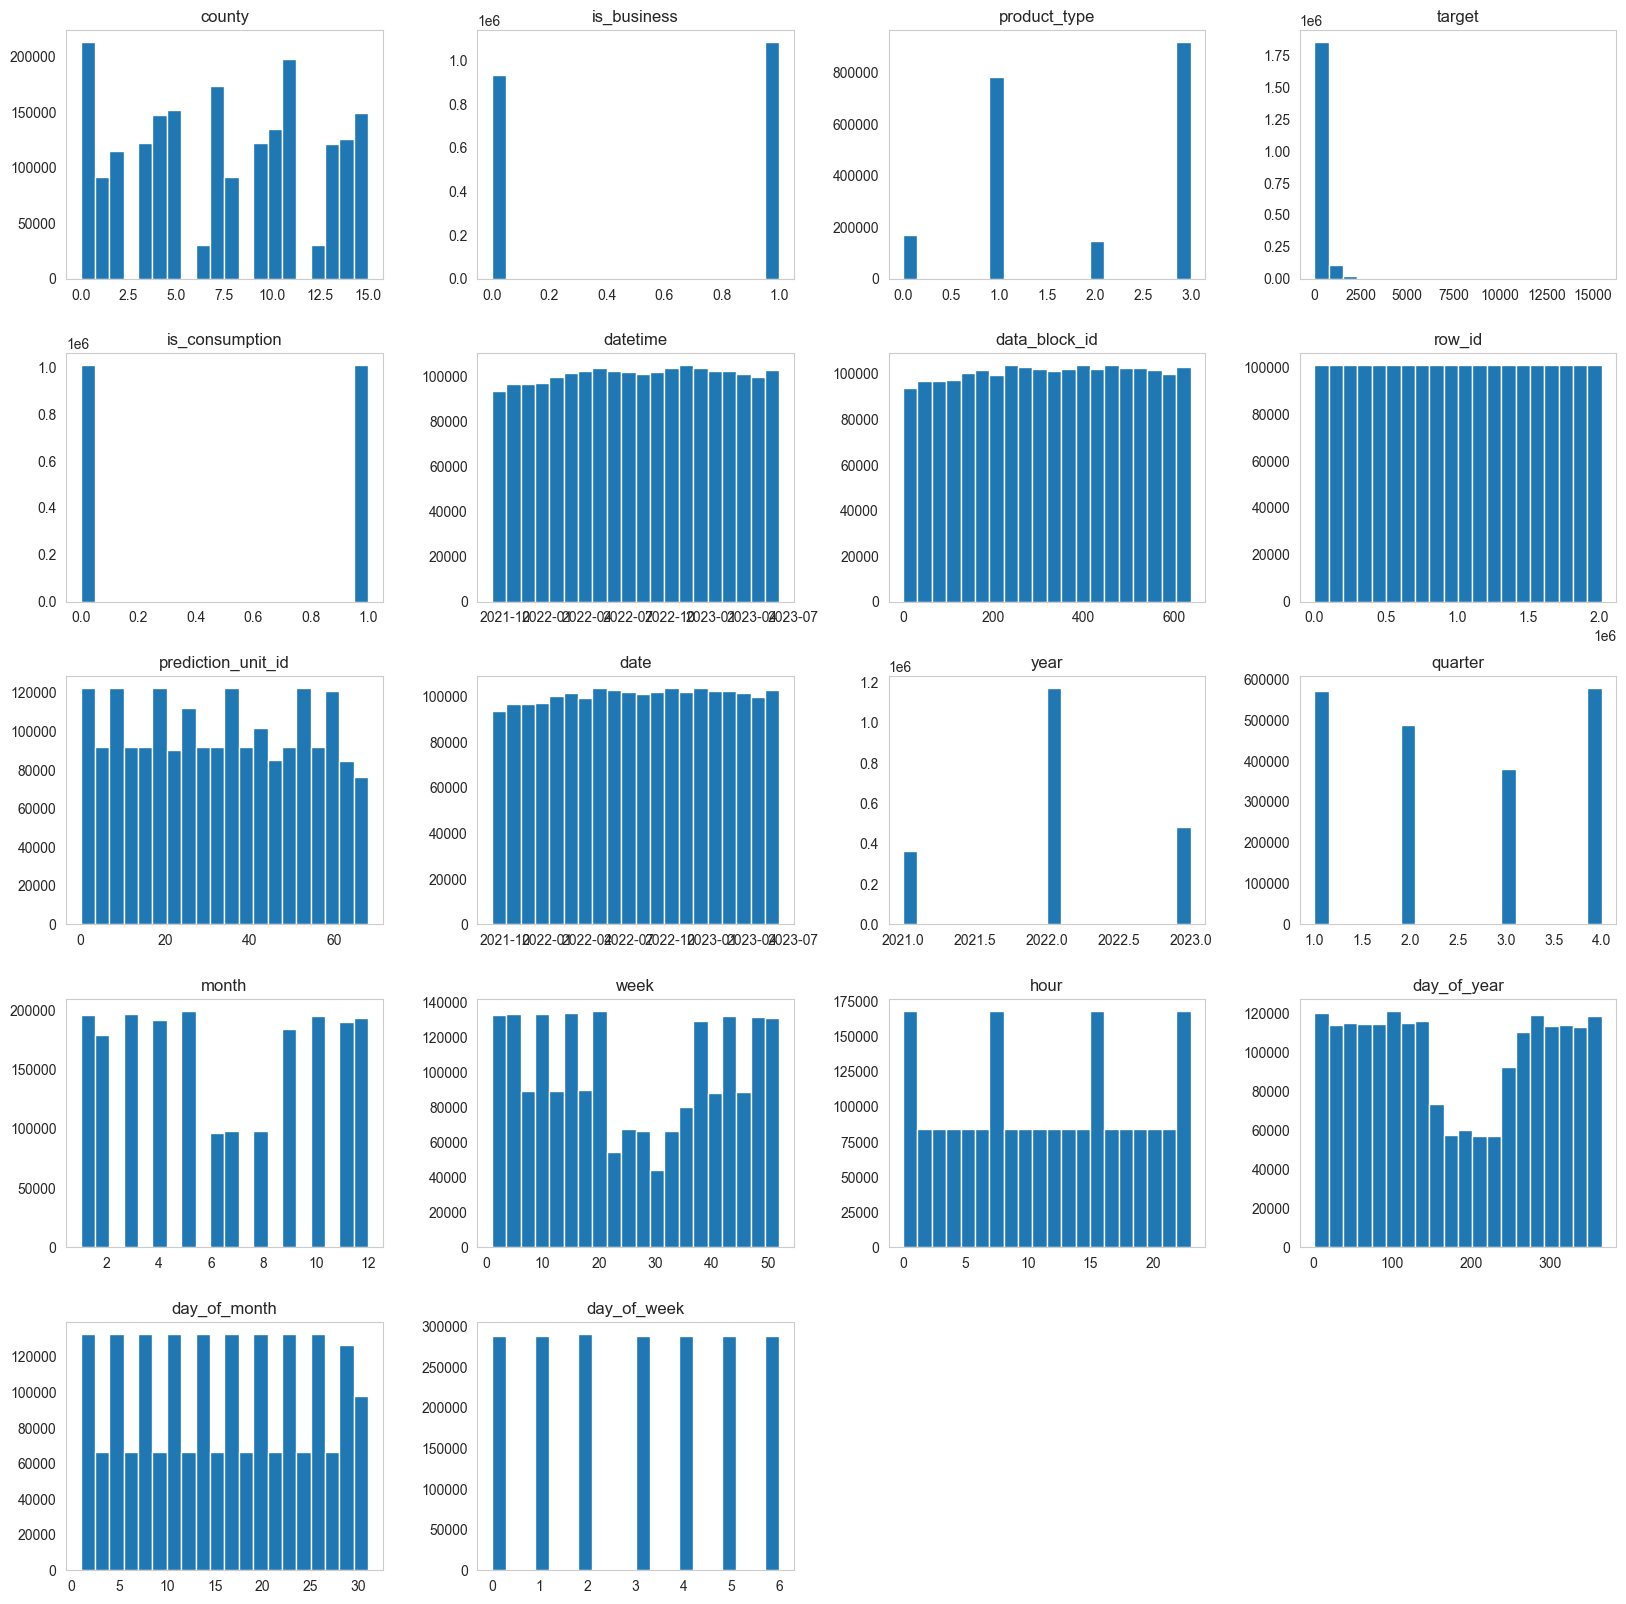

In [17]:
# 数据预处理
# To datetime
data = train
data['datetime'] = pd.to_datetime(data['datetime'])

# Time period features
data['date'] = data['datetime'].dt.normalize()
data['year'] = data['datetime'].dt.year
data['quarter'] = data['datetime'].dt.quarter
data['month'] = data['datetime'].dt.month
data['week'] = data['datetime'].dt.isocalendar().week
data['hour'] = data['datetime'].dt.hour

# Day features
data['day_of_year'] = data['datetime'].dt.day_of_year
data['day_of_month']  = data['datetime'].dt.day
data['day_of_week'] = data['datetime'].dt.day_of_week

data.hist(bins=20,grid=False,figsize=(20,20))
data.head()

#### 小结
通过上图可以看出，train数据中不存在有意义的特征，仅target为目标数据可以用于训练

In [ ]:
# 测试merge train+client

In [ ]:
display_df(train, 'train')
display_df(client, 'client')
display_df(historical_weather, 'historical weather')
display_df(forecast_weather, 'forecast weather')
display_df(electricity, 'electricity prices')
display_df(gas, 'gas prices')
display_df(location, 'location data')

## 二、数据合并

## 三、特征构建以及lag数据构建

## 四、模型训练与评测